# setup

In [1]:
import os, re, json, glob, math, sys, random
from pathlib import Path
from typing import Dict, Iterable, Optional, Sequence, Tuple, Set
from collections import defaultdict, Counter, deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, ScalarFormatter

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# ----------------------------
# Project root (repo)
# ----------------------------
#PROJ_ROOT = Path("/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/OTU-TAXA-FOUNDATION").resolve()
PROJ_ROOT = Path("/home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation")
SRC_DIR = PROJ_ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# ----------------------------
# Local package imports (src/otu_taxa)
# ----------------------------
from otu_taxa.dataloaders_unk_balanced import (
    OTUTaxaDataset,
    MaskingConfig,
    make_tax_only_mask_collator,
)

# If you still use these helper functions in your old test notebook,
# keep them. Otherwise we can remove later.
from otu_taxa.helpers_taxa_prediction import (
    load_vocab_json,
    norm_id,
    parse_tax_to_cols,
    is_unknown,
    evaluate_and_plot_predictions,
)

# UNK-aware metrics / decoding helpers
from otu_taxa.joint_hier_loss_metrics_unk import (
    hierarchical_predict_full_path,
    make_factorized_tax_loss_fn_fast_masked_with_unk,
    get_tax_path_for_label,
    deepest_taxonomy_accuracy_f1,   # often useful in testing
)

# UNK-aware model
from otu_taxa.otu_taxa_transformer_unk import (
    ModelConfig,
    OTUTaxaTransformerEmbedTaxTreeUnkTaxa,
)
from otu_taxa.helpers_pretraining_model import IGNORE_INDEX, set_seed




# load model

In [2]:
# ---------------------------
# Run paths (inside repo)
# ---------------------------
run_name = "pretrain_hier_joint_unk_taxa"
RUN_DIR   = os.path.join(PROJ_ROOT, "runs_microbeatlas", run_name)
META_PATH = os.path.join(RUN_DIR, "meta.json")
CKPT_PATH = os.path.join(RUN_DIR, "best.pt")

with open(META_PATH, "r") as f:
    meta = json.load(f)

# ---------------------------
# External (heavy) dataset location (outside repo)
# Use EXACT same path construction as training
# ---------------------------
DATASET_ROOT = "/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training"
dataset_folder_name = meta.get("dataset_folder_name", "dataset_full_top999")  # prefer meta if saved

dataset_dir = os.path.join(
    DATASET_ROOT,
    "level_97",
    "silva-138.2",
    "incomplete_silva_sintax",
    dataset_folder_name,
)

SAMPLES_JSONL = os.path.join(dataset_dir, "samples.jsonl")
TREE_DIR = os.path.join(dataset_dir, "tree_artifacts")

assert os.path.isfile(SAMPLES_JSONL), f"Missing samples.jsonl: {SAMPLES_JSONL}"
assert os.path.isdir(TREE_DIR), f"Missing tree_artifacts dir: {TREE_DIR}"

print("[INFO] dataset_dir:", dataset_dir)

AFFECTED_OTU_IDS_PATH = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/level_97/taxonomy_reference/silva-138.2/vsearch_incomplete_species_fromOTUS_predictions/affected_otu_ids_from_removed_species.txt"

# ---------------------------
# Rebuild EXACT split used in training
# ---------------------------
seed   = meta.get("seed", 123)
TEST_N = meta.get("TEST_N", 20_000)
VAL_N  = meta.get("VAL_N", 20_000)

set_seed(seed)
random.seed(seed)

ds = OTUTaxaDataset(dataset_dir)
N = len(ds)
print(f"[INFO] Dataset size: N={N}")

TEST_N = min(TEST_N, N)
VAL_N  = min(VAL_N, N - TEST_N)

all_idx = list(range(N))
random.shuffle(all_idx)

test_idx  = sorted(all_idx[:TEST_N])
val_idx   = sorted(all_idx[TEST_N:TEST_N + VAL_N])
train_idx = sorted(all_idx[TEST_N + VAL_N:])

print(f"[SPLIT] Train={len(train_idx)}  Val={len(val_idx)}  Test={len(test_idx)}  (Total N={N})")

train_ds = Subset(ds, train_idx)
val_ds   = Subset(ds, val_idx)
test_ds  = Subset(ds, test_idx)




[INFO] dataset_dir: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999
[INFO] Dataset size: N=1836250
[SPLIT] Train=1796250  Val=20000  Test=20000  (Total N=1836250)


In [3]:
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"

# ---------------------------
# Experiment & run names (NEW layout)
# ---------------------------
run_name = "pretrain_hier_joint_unk_taxa_balanced_ranks"
experiment_name = "runs_microbeatlas"     # runs_microbeatlas/<run_name>

RUN_DIR   = os.path.join(PROJ_ROOT, experiment_name, run_name)
CKPT_PATH = os.path.join(RUN_DIR, "best.pt")
META_PATH = os.path.join(RUN_DIR, "meta.json")

# ---------------------------
# Full MicrobeAtlas dataset path (EXACT training logic)
# IMPORTANT: prefer meta['dataset_folder_name'] if present to avoid mismatches
# ---------------------------
DATASET_ROOT = "/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training"

# NOTE: this is the only functional change I recommend here:
#       use meta.json to pick the dataset folder name when available.
with open(META_PATH, "r") as f:
    meta = json.load(f)

dataset_folder_name = meta.get("dataset_folder_name", "dataset_full_top999")

dataset_dir = os.path.join(
    DATASET_ROOT,
    "level_97",
    "silva-138.2",
    "incomplete_silva_sintax",
    dataset_folder_name,
)

TREE_DIR = os.path.join(dataset_dir, "tree_artifacts")
UNK_VOCAB_PATH = os.path.join(TREE_DIR, "taxonomy_vocab_with_unk.json")
UNK_M_PATH     = os.path.join(TREE_DIR, "descendant_matrix_with_unk.npy")
RANK_IDX_PATH  = os.path.join(TREE_DIR, "rank_idx.npy")

# ---------------------------
# Output location for predictions
# ---------------------------
OUT_DIR = Path(dataset_dir) / "predictions_of_taxa" / experiment_name / run_name
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_JSONL = OUT_DIR / "pred_affected_taxonomy.jsonl"

# ---------------------------
# 1) meta.json strict load (already loaded above)
# ---------------------------
mc = meta.get("model_cfg")
if mc is None:
    raise KeyError("meta.json must contain 'model_cfg'.")

required_mc = ["d_model", "n_layers", "n_heads", "d_ff", "dropout", "activation"]
missing = [k for k in required_mc if k not in mc]
if missing:
    raise KeyError(f"meta['model_cfg'] missing required keys: {missing}")

# ---------------------------
# 2) dataset sizes + strict consistency checks
# ---------------------------
ds = OTUTaxaDataset(dataset_dir)
O_ds = ds.O
T_real_ds = ds.T

ds_meta = meta.get("dataset", {})
if not ds_meta:
    raise KeyError("meta.json must contain 'dataset' with O/T info.")

mO     = ds_meta.get("O")
T_real = ds_meta.get("T_real")
T_base = ds_meta.get("T_base")

if mO is None or T_real is None or T_base is None:
    raise KeyError("meta['dataset'] must contain 'O', 'T_real', 'T_base'.")

if mO != O_ds:
    raise ValueError(f"Dataset O mismatch: meta O={mO}, dataset O={O_ds}")

if T_real != T_real_ds:
    raise ValueError(f"Dataset T_real mismatch: meta T_real={T_real}, dataset T={T_real_ds}")

# specials (exact same convention as training)
pad_otu_id  = O_ds
mask_otu_id = O_ds + 1

pad_tax_id  = T_base
mask_tax_id = T_base + 1

n_otus = O_ds + 2
n_taxa = T_base + 2

# ---------------------------
# 3) Load UNK tree artifacts required for hierarchical loss/decoding
# ---------------------------
with open(UNK_VOCAB_PATH, "r") as f:
    tax_vocab_unk = json.load(f)
if len(tax_vocab_unk) != T_base:
    raise ValueError(f"UNK vocab length mismatch: len(vocab_unk)={len(tax_vocab_unk)} vs T_base={T_base}")

M_np = np.load(UNK_M_PATH)  # [T_base, T_base]
if M_np.shape != (T_base, T_base):
    raise ValueError(f"Descendant matrix shape mismatch: {M_np.shape} vs expected {(T_base, T_base)}")

rank_idx = np.load(RANK_IDX_PATH)  # [T_base]
if rank_idx.shape[0] != T_base:
    raise ValueError(f"rank_idx length mismatch: {rank_idx.shape} vs T_base={T_base}")

M_tensor = torch.from_numpy(M_np).to(DEVICE)
rank_idx_t = torch.from_numpy(rank_idx).to(DEVICE)

# ---------------------------
# 4) Build loss fn (keeps model construction identical to training)
# ---------------------------
hier_tax_loss_fn = make_factorized_tax_loss_fn_fast_masked_with_unk(
    M_tensor=M_tensor,
    rank_idx=rank_idx_t,
    tax_vocab=tax_vocab_unk,
    T_base=T_base,
)

# ---------------------------
# 5) Instantiate model exactly and strict checkpoint load
# ---------------------------
cfg = ModelConfig(**mc)

model = OTUTaxaTransformerEmbedTaxTreeUnkTaxa(
    n_otus=n_otus,
    n_taxa=n_taxa,
    pad_otu_id=pad_otu_id,
    pad_tax_id=pad_tax_id,
    config=cfg,
    tax_loss_fn=hier_tax_loss_fn,   # IMPORTANT for parity with training
)

raw = torch.load(CKPT_PATH, map_location="cpu")
if not isinstance(raw, dict):
    raise TypeError("Checkpoint must be a dict-like object.")

if "model" in raw and isinstance(raw["model"], dict):
    sd = raw["model"]
elif "state_dict" in raw and isinstance(raw["state_dict"], dict):
    sd = raw["state_dict"]
else:
    raise KeyError("Checkpoint must contain either 'model' or 'state_dict'.")

def strip_prefix_if_all(state_dict, prefix):
    keys = list(state_dict.keys())
    if keys and all(k.startswith(prefix) for k in keys):
        return {k[len(prefix):]: v for k, v in state_dict.items()}
    return state_dict

sd = strip_prefix_if_all(sd, "model.")
sd = strip_prefix_if_all(sd, "module.")

model.load_state_dict(sd, strict=True)
model.to(DEVICE).eval()

print("[OK] strict load succeeded; model on", DEVICE)
print(f"[INFO] dataset_dir={dataset_dir}")
print(f"[INFO] O={O_ds}, T_real={T_real}, T_base={T_base}, n_taxa={n_taxa}")
print(f"[INFO] OUT_JSONL={OUT_JSONL}")

# -----------------------------------
# Build tax_id2name mapping (GLOBAL)
# -----------------------------------
if isinstance(tax_vocab_unk, list):
    tax_id2name = {i: name for i, name in enumerate(tax_vocab_unk)}
elif isinstance(tax_vocab_unk, dict):
    tax_id2name = {int(k): v for k, v in tax_vocab_unk.items()}
else:
    raise TypeError(f"Unsupported taxonomy vocab type: {type(tax_vocab_unk)}")

if len(tax_id2name) != T_base:
    raise ValueError(f"tax_id2name size mismatch: len={len(tax_id2name)} vs T_base={T_base}")

print(f"[INFO] tax_id2name created (size={len(tax_id2name)})")
print(f"[INFO] preview taxonomy names: {[tax_id2name[i] for i in range(min(5, T_base))]}")


UNK ids per rank: [6928, 6929, 6930, 6931, 6932, 6933, 6934]


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[OK] strict load succeeded; model on cuda:1
[INFO] dataset_dir=/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999
[INFO] O=62200, T_real=6929, T_base=6935, n_taxa=6937
[INFO] OUT_JSONL=/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/predictions_of_taxa/runs_microbeatlas/pretrain_hier_joint_unk_taxa_balanced_ranks/pred_affected_taxonomy.jsonl
[INFO] tax_id2name created (size=6935)
[INFO] preview taxonomy names: ['c:028H05-P-BN-P5', 'c:055B07-P-DI-P58', 'c:113B434', 'c:AB64A-17', 'c:AEGEAN-245']


# predictions

In [4]:
def load_affected_otu_ids_txt(path: str, otu_name2id: dict) -> Set[int]:
    """
    Load affected OTUs from a text file.
    Supports:
      - integer OTU ids (as strings)
      - OTU names like '90_1015;96_21955;97_71802'
    """
    ids = set()
    missing = []

    with open(path, "r") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue

            # Case 1: already an integer OTU id
            if s.isdigit():
                ids.add(int(s))
                continue

            # Case 2: OTU name → map to id
            if otu_name2id is not None and s in otu_name2id:
                ids.add(int(otu_name2id[s]))
            else:
                missing.append(s)

    if missing:
        print(
            f"[WARN] {len(missing)} affected OTUs could not be mapped to dataset OTU ids "
            f"(showing first 10): {missing[:10]}"
        )

    return ids


In [ ]:
# --------------------------------------------------------- 
# 0) Reproducibility for the OTU selection step
# ---------------------------------------------------------
seed = meta.get("seed", 123)
random.seed(seed)


# ---------------------------------------------------------
# 1) OTU vocab mappings (optional; keep as-is)
# ---------------------------------------------------------
otu_vocab_candidates = [
    os.path.join(dataset_dir, "otu_vocab.json"),
    os.path.join(TREE_DIR, "otu_vocab.json"),
]
otu_vocab_path = next((p for p in otu_vocab_candidates if os.path.isfile(p)), None)

otu_id2name = None
otu_name2id = None
if otu_vocab_path is not None:
    with open(otu_vocab_path, "r") as f:
        otu_vocab = json.load(f)
    if isinstance(otu_vocab, dict):
        otu_id2name = {int(k): v for k, v in otu_vocab.items()}
        otu_name2id = {v: k for k, v in otu_id2name.items()}
    elif isinstance(otu_vocab, list):
        otu_id2name = {i: n for i, n in enumerate(otu_vocab)}
        otu_name2id = {n: i for i, n in otu_id2name.items()}
    print(f"[INFO] Loaded OTU vocab: {otu_vocab_path}  (size={len(otu_id2name)})")
else:
    print("[WARN] OTU vocab json not found; proceeding without names (IDs only).")


affected_otu_ids = load_affected_otu_ids_txt(
    AFFECTED_OTU_IDS_PATH,
    otu_name2id=otu_name2id,
)

print(f"[AFFECTED] preview: {sorted(list(affected_otu_ids))[:20]}")


# ---------------------------------------------------------
# 2) Sanity check dataset sizes (parity with model block)
# ---------------------------------------------------------
O_eval, T_real_eval = ds.O, ds.T
if O_eval != O_ds:
    raise ValueError(f"OTU mismatch: model block O={O_ds}, dataset O={O_eval}")
if T_real_eval != T_real:
    raise ValueError(f"T_real mismatch: model meta T_real={T_real}, dataset T={T_real_eval}")

print(f"[INFO] Eval setup: O={O_eval}, T_real={T_real_eval}, T_base={T_base}")

# ---------------------------------------------------------
# 3) Build OTU pool from test_ds (Subset) (keep as-is)
# ---------------------------------------------------------
def build_otu_pool_from_subset(subset_ds, otu_key="otus", probe=None, return_counts=True):
    pool = set()
    counts = Counter()
    n_seen = 0

    L = len(subset_ds)
    limit = L if probe is None else min(L, int(probe))

    for i in range(limit):
        rec = subset_ds[i]
        if not isinstance(rec, dict):
            continue
        otus = rec.get(otu_key, [])
        if torch.is_tensor(otus):
            otus = otus.view(-1).tolist()
        for o in otus:
            oi = int(o.item() if torch.is_tensor(o) else o)
            pool.add(oi)
            if return_counts:
                counts[oi] += 1
        n_seen += 1

    return (pool, counts, n_seen) if return_counts else (pool, n_seen)

otu_pool, otu_counts, n_seen = build_otu_pool_from_subset(test_ds, otu_key="otus", probe=None, return_counts=True)

print(f"[POOL] scanned test samples: {n_seen}")
print(f"[POOL] unique OTUs in test set: {len(otu_pool)}")
print(f"[POOL] preview OTU IDs: {sorted(list(otu_pool))[:15]}")

# ---------------------------------------------------------
# 4) REPLACE random OTUs with: affected OTUs intersect test OTU pool
# ---------------------------------------------------------
mask_otu_ids = sorted(list(affected_otu_ids.intersection(otu_pool)))

print(f"[AFFECTED∩TEST] affected OTUs present in test set: {len(mask_otu_ids):,}")
if len(affected_otu_ids) > 0:
    print(f"[AFFECTED∩TEST] coverage: {len(mask_otu_ids)/float(len(affected_otu_ids)):.2%} "
          f"(of all affected OTUs)")
print(f"[AFFECTED∩TEST] preview: {mask_otu_ids[:20]}")

if len(mask_otu_ids) == 0:
    raise ValueError(
        "No affected OTUs appear in the test set. "
        "Check OTU id space alignment between affected list and OTUTaxaDataset."
    )

# Optional: frequencies in test set (kept from your original logic)
freq_preview = [(oid, otu_counts.get(oid, 0)) for oid in mask_otu_ids[:15]]
print("[AFFECTED∩TEST] frequency preview (otu_id, count_in_test_scan):")
print(freq_preview)

# ---------------------------------------------------------
# 5) Descendant matrix + rank_idx loading
# ---------------------------------------------------------

if not os.path.isfile(UNK_M_PATH):
    raise FileNotFoundError(f"Missing UNK descendant matrix: {UNK_M_PATH}")

M_np = np.load(UNK_M_PATH)  # expected shape [T_base, T_base]
if M_np.shape != (T_base, T_base):
    raise ValueError(
        f"descendant_matrix_with_unk shape mismatch: "
        f"expected ({T_base}, {T_base}), got {M_np.shape}"
    )

M_tensor = torch.from_numpy(M_np)  # CPU tensor

if not os.path.isfile(RANK_IDX_PATH):
    raise FileNotFoundError(f"Missing rank_idx.npy: {RANK_IDX_PATH}")

rank_idx_np = np.load(RANK_IDX_PATH)  # expected shape [T_base]
if rank_idx_np.shape[0] != T_base:
    raise ValueError(
        f"rank_idx length mismatch: expected ({T_base},), got {rank_idx_np.shape}"
    )

valid = set([-1, 0, 1, 2, 3, 4, 5, 6])
bad = sorted(set(int(x) for x in np.unique(rank_idx_np)) - valid)
if bad:
    raise ValueError(f"rank_idx contains invalid values: {bad}")

rank_idx = torch.from_numpy(rank_idx_np.astype(np.int64))  # CPU tensor, long

M_dev = M_tensor.to(DEVICE)
rank_idx_dev = rank_idx.to(DEVICE)

print(
    f"[INFO] descendant_matrix_with_unk loaded from: {UNK_M_PATH}, "
    f"shape={M_np.shape}"
)
print(
    f"[INFO] rank_idx loaded from: {RANK_IDX_PATH}, "
    f"shape={rank_idx_np.shape}, unique={sorted(set(rank_idx_np.tolist()))}"
)


[INFO] Loaded OTU vocab: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/otu_vocab.json  (size=62200)
[WARN] 788 affected OTUs could not be mapped to dataset OTU ids (showing first 10): ['90_1015;96_21955;97_71802', '90_10304;96_44834;97_57458', '90_1043;96_25689;97_76253', '90_104;96_21964;97_40372', '90_104;96_50355;97_64824', '90_104;96_59769;97_77397', '90_10518;96_45799;97_58769', '90_10612;96_46197;97_59287', '90_10634;96_46301;97_59430', '90_10634;96_64931;97_84238']
[AFFECTED] preview: [179, 433, 584, 808, 914, 981, 1236, 1306, 1388, 1666, 1710, 1718, 1781, 1796, 1811, 1911, 1950, 1981, 2030, 2086]
[INFO] Eval setup: O=62200, T_real=6929, T_base=6935
[POOL] scanned test samples: 20000
[POOL] unique OTUs in test set: 59446
[POOL] preview OTU IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[AFFECTED∩TEST] affected OTUs present in test set: 692
[AFFECTED∩TEST] coverage: 94.79% (of all

In [6]:
import torch

def make_tax_only_mask_collator(dataset, affected_ids, *, T_base: int, max_len=None):
    O = dataset.O
    pad_otu_id, mask_otu_id = O, O + 1

    pad_tax_id, mask_tax_id = T_base, T_base + 1  # IMPORTANT (matches model)

    affected_ids = set(map(int, affected_ids))

    def collate(batch):
        lengths = [len(b["otus"]) for b in batch]
        L = max_len if max_len is not None else max(lengths)
        B = len(batch)

        input_otus = torch.full((B, L), pad_otu_id, dtype=torch.long)
        input_taxa = torch.full((B, L), pad_tax_id, dtype=torch.long)
        attention_mask = torch.zeros((B, L), dtype=torch.bool)

        masked_positions = []
        sample_ids = []
        true_taxa = []

        for i, rec in enumerate(batch):
            otus = torch.tensor(rec["otus"], dtype=torch.long)
            taxa = torch.tensor(rec["taxa"], dtype=torch.long)

            L_i = min(L, len(otus))
            input_otus[i, :L_i] = otus[:L_i]
            input_taxa[i, :L_i] = taxa[:L_i]
            attention_mask[i, :L_i] = True

            aff_mask = torch.tensor(
                [int(int(x) in affected_ids) for x in otus[:L_i]],
                dtype=torch.bool
            )

            input_taxa[i, :L_i][aff_mask] = mask_tax_id

            pos_idx = torch.nonzero(aff_mask, as_tuple=False).view(-1).tolist()
            masked_positions.append(pos_idx)

            sample_ids.append(rec["sample_id"])

            # FIX: store the aligned/truncated gold taxonomy for this sample
            gold = torch.full((L,), pad_tax_id, dtype=torch.long)
            gold[:L_i] = taxa[:L_i]
            true_taxa.append(gold)

        return {
            "input_otus": input_otus,
            "input_taxa": input_taxa,
            "attention_mask": attention_mask,
            "masked_positions": masked_positions,
            "sample_ids": sample_ids,
            "true_taxa": true_taxa,  # list[Tensor(L,)]
        }

    return collate


In [7]:
# -------------------------
# Output (UPDATED: distinguish affected vs random)
# -------------------------
PRED_DIR = Path(RUN_DIR) / "predictions"
PRED_DIR.mkdir(parents=True, exist_ok=True)

# Tag this experiment explicitly
AFFECTED_TAG = "affected_removed_species_20pct_seed123"

OUT_JSONL_AFFECTED = PRED_DIR / f"pred_{AFFECTED_TAG}_taxonomy_per_rank.jsonl"
if OUT_JSONL_AFFECTED.exists():
    OUT_JSONL_AFFECTED.unlink()

print(f"[INFO] Writing AFFECTED-OTU predictions to: {OUT_JSONL_AFFECTED}")

RANK_LETTERS = ['k', 'p', 'c', 'o', 'f', 'g', 's']

# -------------------------
# Choose AFFECTED OTUs (replace random selection)
# -------------------------
# You should already have:
#   affected_otu_ids : Set[int]   (mapped to dataset id space)
#   otu_pool         : Set[int]   (from test set scan)
# We restrict to those actually appearing in test set:
affected_in_test = set(affected_otu_ids).intersection(otu_pool)

print(f"[AFFECTED] total affected OTUs loaded: {len(affected_otu_ids):,}")
print(f"[AFFECTED∩TEST] affected OTUs present in test set: {len(affected_in_test):,}")
print(f"[AFFECTED∩TEST] preview: {sorted(list(affected_in_test))[:15]}")

if len(affected_in_test) == 0:
    raise ValueError(
        "No affected OTUs appear in the test set. "
        "Check OTU-id mapping and the affected list definition."
    )

mask_otu_ids = affected_in_test  # name kept for parity with old loop

# -------------------------
# KEEP existing collator (unchanged), but use affected IDs
# -------------------------
max_len = meta.get("max_len", 500)  # keep as before
collate = make_tax_only_mask_collator(ds, mask_otu_ids, T_base=T_base, max_len=500)

# -------------------------
# Batch iterator over test_ds only
# Same logic: keep only samples that contain ≥1 target OTU
# -------------------------
def batch_iter_only_affected_subset(subset, batch_size: int, affected_ids: set):
    batch = []
    matched = 0

    for i in range(len(subset)):
        rec = subset[i]

        otus = rec.get("otus", [])
        if torch.is_tensor(otus):
            otus = otus.view(-1).tolist()

        if set(map(int, otus)) & affected_ids:
            matched += 1
            batch.append(rec)
            if len(batch) == batch_size:
                yield collate(batch)
                batch.clear()

    if batch:
        yield collate(batch)

    print(f"[INFO] TEST filtering: subset size={len(subset)} | matched with ≥1 target OTU: {matched}")

# -------------------------
# Helpers for name mapping (robust)
# -------------------------
def _tax_name(tid: int):
    if "tax_id2name" in globals() and tax_id2name is not None:
        if isinstance(tax_id2name, dict):
            return tax_id2name.get(int(tid), f"<id:{int(tid)}>")
        if isinstance(tax_id2name, list) and 0 <= tid < len(tax_id2name):
            return tax_id2name[tid]
    if "tax_vocab_unk" in globals() and tax_vocab_unk is not None:
        if isinstance(tax_vocab_unk, dict):
            return tax_vocab_unk.get(str(int(tid)), tax_vocab_unk.get(int(tid), f"<id:{int(tid)}>"))
        if isinstance(tax_vocab_unk, list) and 0 <= tid < len(tax_vocab_unk):
            return tax_vocab_unk[tid]
    return f"<id:{int(tid)}>"

def _otu_name(oid: int):
    if "otu_id2name" in globals() and otu_id2name is not None:
        return otu_id2name.get(int(oid), f"<otu:{int(oid)}>")
    return f"<otu:{int(oid)}>"

# -------------------------
# Prediction loop (UNCHANGED except output path variable)
# -------------------------
BATCH_SIZE = 4
total_samples = 0
total_masked_positions = 0

model.eval()
with torch.no_grad():
    with open(OUT_JSONL_AFFECTED, "w") as fjsonl:
        for batch in batch_iter_only_affected_subset(
            test_ds, BATCH_SIZE, mask_otu_ids
        ):
            input_otus = batch["input_otus"].to(DEVICE)
            input_taxa = batch["input_taxa"].to(DEVICE)
            attn_mask  = batch["attention_mask"].to(DEVICE)

            out = model(
                input_otus=input_otus,
                input_taxa=input_taxa,
                attention_mask=attn_mask,
            )

            logits_tax = None
            for k in ("logits_tax", "tax_logits", "logits_taxa"):
                if isinstance(out, dict) and k in out:
                    logits_tax = out[k]
                    break
            if logits_tax is None:
                raise KeyError("Model forward output does not contain taxonomy logits.")

            # block PAD_TAX and MASK_TAX (indices T_base, T_base+1)
            if pad_tax_id < logits_tax.size(-1):
                logits_tax[:, :, pad_tax_id] = float("-inf")
            if mask_tax_id < logits_tax.size(-1):
                logits_tax[:, :, mask_tax_id] = float("-inf")

            for bi, sid in enumerate(batch["sample_ids"]):
                pos_list = batch["masked_positions"][bi]
                if not pos_list:
                    continue
                total_samples += 1

                true_seq = batch["true_taxa"][bi]

                for pos in pos_list:
                    logits_vec = logits_tax[bi, pos]
                    logits_base = logits_vec[:T_base]

                    path_pred = hierarchical_predict_full_path(
                        logits_vec=logits_base,
                        M_tensor=M_dev,
                        rank_idx=rank_idx_dev,
                        R=7,
                    )

                    pred_by_rank = {}
                    for r, ch in enumerate(RANK_LETTERS):
                        pid = path_pred.get(r, None)
                        if pid is None:
                            continue
                        pred_by_rank[ch] = {
                            "tax_id": int(pid),
                            "tax_name": _tax_name(int(pid)),
                        }

                    true_val = true_seq[pos]
                    true_tid = int(true_val.item() if torch.is_tensor(true_val) else true_val)

                    otu_id = int(batch["input_otus"][bi, pos].item())

                    if 0 <= true_tid < T_base:
                        r_true = int(rank_idx_dev[true_tid].item())
                    else:
                        r_true = -1

                    if 0 <= r_true < len(RANK_LETTERS):
                        ch_true = RANK_LETTERS[r_true]
                        pid_deep = path_pred.get(r_true, None)
                        pred_flat = {
                            "tax_id": int(pid_deep) if pid_deep is not None else None,
                            "tax_name": _tax_name(int(pid_deep)) if pid_deep is not None else None,
                            "rank": ch_true,
                        }
                    else:
                        pred_flat = {"tax_id": None, "tax_name": None, "rank": None}

                    rec = {
                        "sample_id": sid,
                        "position": int(pos),
                        "otu_id": int(otu_id),
                        "otu_name": _otu_name(int(otu_id)),
                        "true_tax_id": int(true_tid),
                        "true_tax_name": _tax_name(int(true_tid)),
                        "pred_flat": pred_flat,
                        "pred_by_rank": pred_by_rank,
                        # Optional but useful provenance tag:
                        "experiment_tag": AFFECTED_TAG,
                    }

                    fjsonl.write(json.dumps(rec) + "\n")
                    total_masked_positions += 1

print(f"[DONE] wrote AFFECTED predictions to: {OUT_JSONL_AFFECTED}")
print(f"[INFO] samples with ≥1 masked affected OTU: {total_samples}")
print(f"[INFO] total masked positions (affected OTUs): {total_masked_positions}")


[INFO] Writing AFFECTED-OTU predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas/pretrain_hier_joint_unk_taxa_balanced_ranks/predictions/pred_affected_removed_species_20pct_seed123_taxonomy_per_rank.jsonl
[AFFECTED] total affected OTUs loaded: 730
[AFFECTED∩TEST] affected OTUs present in test set: 692
[AFFECTED∩TEST] preview: [179, 433, 584, 808, 914, 981, 1236, 1306, 1388, 1666, 1710, 1718, 1781, 1796, 1811]
[INFO] TEST filtering: subset size=20000 | matched with ≥1 target OTU: 10561
[DONE] wrote AFFECTED predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas/pretrain_hier_joint_unk_taxa_balanced_ranks/predictions/pred_affected_removed_species_20pct_seed123_taxonomy_per_rank.jsonl
[INFO] samples with ≥1 masked affected OTU: 10513
[INFO] total masked positions (affected OTUs): 24200


In [8]:
import re

# -----------------------------
# Diagnostics for affected OTUs
# -----------------------------

print("[DEBUG] AFFECTED_OTU_IDS_PATH =", AFFECTED_OTU_IDS_PATH)

# 1) Read raw affected file
with open(AFFECTED_OTU_IDS_PATH, "r") as f:
    raw_lines = [ln.strip() for ln in f if ln.strip()]

print("[DEBUG] raw affected entries in file:", len(raw_lines))
print("[DEBUG] raw preview:", raw_lines[:5])

# 2) Normalization helper (same logic we should use everywhere)
def normalize_otu_name(s: str) -> str:
    return re.sub(r"\s+", "", str(s)).strip().strip('"').strip("'")

# 3) Try mapping to dataset OTU ids
mapped_ids = set()
missing = []

for s in raw_lines:
    ss = normalize_otu_name(s)

    # case A: already integer
    if ss.isdigit():
        mapped_ids.add(int(ss))
        continue

    # case B: OTU name -> dataset id
    if otu_name2id is not None and ss in otu_name2id:
        mapped_ids.add(int(otu_name2id[ss]))
    else:
        missing.append(s)

print("\n[DEBUG] mapping results:")
print("  mapped affected OTUs:", len(mapped_ids))
print("  missing / unmapped OTUs:", len(missing))

if missing:
    print("  missing preview (first 10):")
    for x in missing[:10]:
        print("   ", x)

# 4) Dataset-level sanity
print("\n[DEBUG] dataset OTU vocab size (ds.O):", ds.O)

# 5) Intersection with test set
mapped_in_test = mapped_ids & otu_pool
print("\n[DEBUG] mapped affected OTUs in test set:", len(mapped_in_test))

if mapped_ids:
    print(
        "[DEBUG] coverage in test: {:.2%}".format(
            len(mapped_in_test) / len(mapped_ids)
        )
    )

# 6) Final consistency check
print("\n[SUMMARY]")
print(f"  affected (file)        : {len(raw_lines)}")
print(f"  affected (mapped)      : {len(mapped_ids)}")
print(f"  affected (mapped∩test) : {len(mapped_in_test)}")


[DEBUG] AFFECTED_OTU_IDS_PATH = /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/level_97/taxonomy_reference/silva-138.2/vsearch_incomplete_species_fromOTUS_predictions/affected_otu_ids_from_removed_species.txt
[DEBUG] raw affected entries in file: 1518
[DEBUG] raw preview: ['90_1015;96_21955;97_71802', '90_1015;96_55630;97_71800', '90_10304;96_44834;97_57458', '90_1043;96_25689;97_76253', '90_1049;96_12459;97_15129']

[DEBUG] mapping results:
  mapped affected OTUs: 730
  missing / unmapped OTUs: 788
  missing preview (first 10):
    90_1015;96_21955;97_71802
    90_10304;96_44834;97_57458
    90_1043;96_25689;97_76253
    90_104;96_21964;97_40372
    90_104;96_50355;97_64824
    90_104;96_59769;97_77397
    90_10518;96_45799;97_58769
    90_10612;96_46197;97_59287
    90_10634;96_46301;97_59430
    90_10634;96_64931;97_84238

[DEBUG] dataset OTU vocab size (ds.O): 62200

[DEBUG] mapped affected OTUs in test set: 692
[DEBUG] coverage in test: 94.79%

[SUMMARY]
  affec

# print predictions

In [ ]:
from otu_taxa.metrics_figures import (
    evaluate_and_plot_predictions_multilabel, 
    plot_per_level_accuracy_hierarchical_from_arrays, 
    load_predictions_with_pred_gold, 
    strict_error_origin_matrix_and_rankACC, 
    plot_strict_matrix_with_rankACC, 
    plot_error_origin_matrix_rowpct_colored,
    compute_global_rankACC, 
    build_accuracy_vs_rankACC_table
)

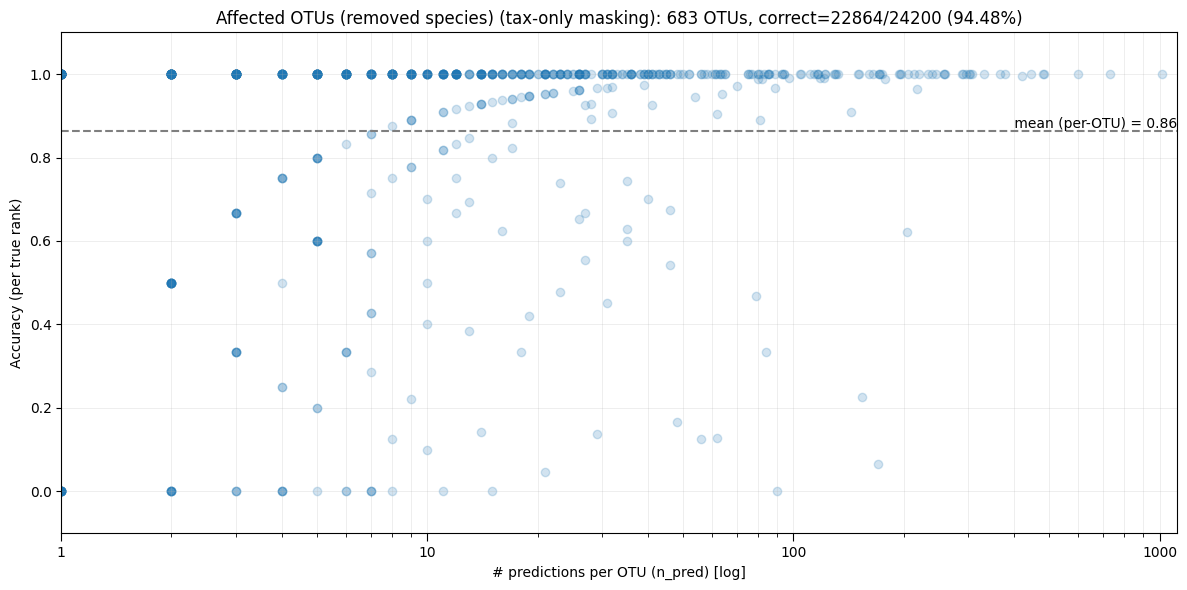

[INFO] multilabel eval: 10513 unique samples, 24200 predictions, 683 OTUs | correct=22864/24200 (94.48%)


In [10]:
df_rows, df_per_otu, summary, fig = evaluate_and_plot_predictions_multilabel(
    OUT_JSONL_AFFECTED,
    title_prefix="Affected OTUs (removed species) (tax-only masking)",
    make_plot=True,
    test_ids=None,
)


In [11]:
from otu_taxa.dataloaders_unk_balanced import build_tax2ancestor_at_rank, build_tax2rank_from_vocab

RANKS = ("k","p","c","o","f","g","s")

# M_np must be the descendant closure used by the hierarchical loss: shape [T_base, T_base]
# tax_vocab_list must be length T_base (UNK-extended)
tax2rank = build_tax2rank_from_vocab(tax_vocab_unk)

ancestor_at_rank = {
    r: build_tax2ancestor_at_rank(
        M_np=M_np,                    # np.ndarray [T_base, T_base]
        tax_vocab_list=tax_vocab_unk,  # list[str] length T_base
        target_rank=r,
        missing_value=-1,
    )
    for r in RANKS
}

# quick sanity
for r in RANKS:
    assert len(ancestor_at_rank[r]) == M_np.shape[0]
print("[OK] built ancestor arrays for ranks:", RANKS)


[OK] built ancestor arrays for ranks: ('k', 'p', 'c', 'o', 'f', 'g', 's')


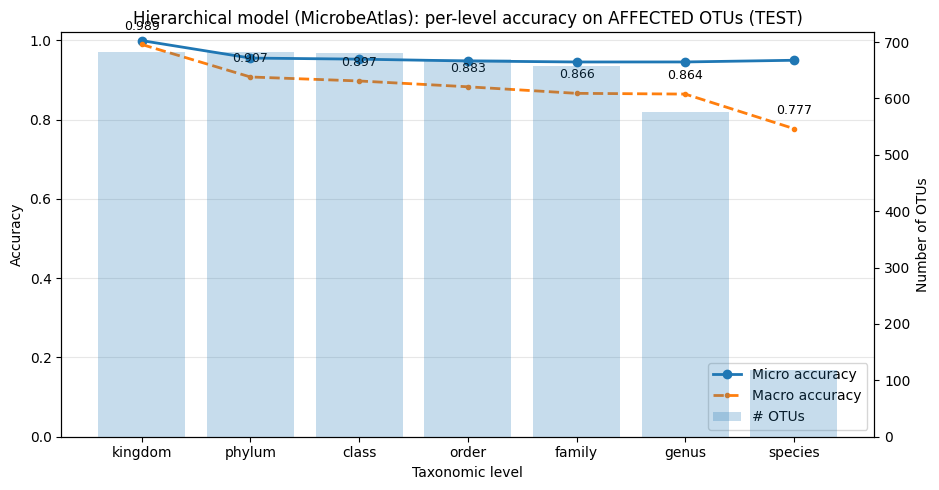

[INFO] overall micro (avg over levels) = 0.956, mean macro (avg over levels) = 0.883


,level,n_rows_used,n_otus_used,micro_acc,macro_acc
0,kingdom,24200,683,0.9992,0.9894
1,phylum,24158,682,0.9551,0.9074
2,class,24156,680,0.9524,0.8973
3,order,24027,670,0.9477,0.8827
4,family,23664,657,0.9452,0.8661
5,genus,22407,576,0.9453,0.8643
6,species,3112,119,0.9496,0.7771


In [13]:
JSONL_PER_RANK = OUT_JSONL_AFFECTED  # <-- change from OUT_JSONL_RANDOM

df_all, per_level_summary, overall, fig = plot_per_level_accuracy_hierarchical_from_arrays(
    jsonl_path=JSONL_PER_RANK,
    ancestor_at_rank=ancestor_at_rank,
    test_ids=None,
    ranks=("k","p","c","o","f","g","s"),
    title="Hierarchical model (MicrobeAtlas): per-level accuracy on AFFECTED OTUs (TEST)"
)

display(per_level_summary)

In [ ]:
from matplotlib.gridspec import GridSpec


RANKS = ("k","p","c","o","f","g","s")


# ------------------------------------------------------------
# 0) Build gold ancestor arrays 
# ------------------------------------------------------------
def build_ancestor_arrays_all_ranks(M_np, tax_vocab_unk, ranks=RANKS, missing_value=-1):
    """
    Returns dict rank -> dense list length T_base:
      ancestor_at_rank[r][t] = ancestor tax_id at rank r, else -1.
    """
    ancestor_at_rank = {}
    for r in ranks:
        ancestor_at_rank[r] = build_tax2ancestor_at_rank(
            M_np=M_np,
            tax_vocab_list=tax_vocab_unk,
            target_rank=r,
            missing_value=missing_value,
        )
    return ancestor_at_rank


Global rankACC: 0.9575


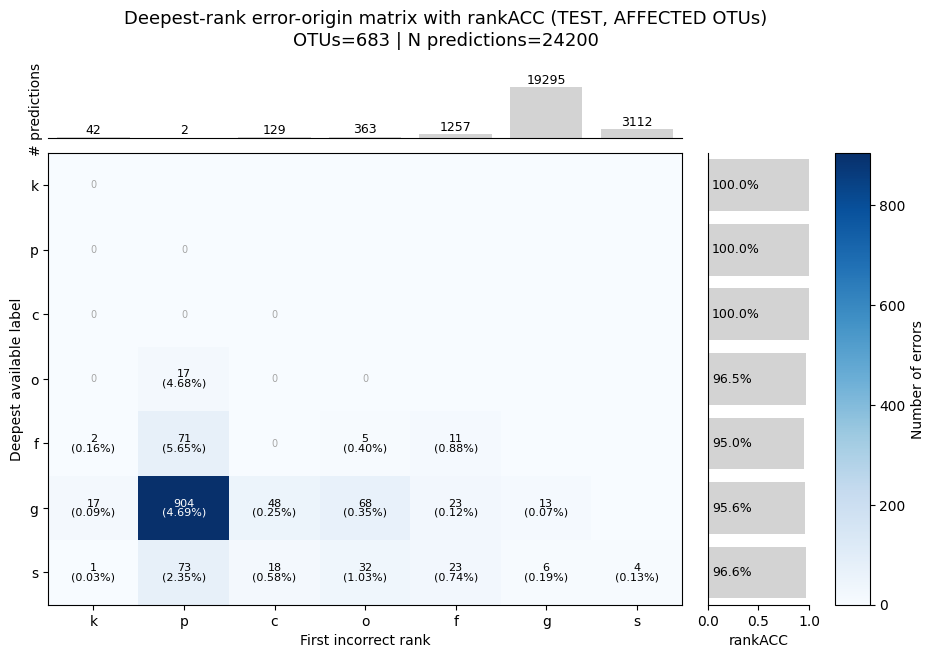

In [15]:

# 1) Build ancestor arrays from UNK artifacts 
ancestor_at_rank = build_ancestor_arrays_all_ranks(
    M_np=M_np,
    tax_vocab_unk=tax_vocab_unk,
    ranks=RANKS,
    missing_value=-1,
)

# 2) Load predictions from the AFFECTED jsonl
df = load_predictions_with_pred_gold(
    jsonl_path=OUT_JSONL_AFFECTED,     
    ancestor_at_rank=ancestor_at_rank,
    ranks=RANKS,
)

# 3) Strict matrix + meta for plot
counts_strict, meta_strict = strict_error_origin_matrix_and_rankACC(df, ranks=RANKS)

# 4) Plot 
plot_strict_matrix_with_rankACC(
    counts_strict,
    meta_strict,
    title="Deepest-rank error-origin matrix with rankACC (TEST, AFFECTED OTUs)",
    ranks=RANKS,
    df=df,
    otu_col="otu_id",
    show_zeros_lower=True,
)

# 5) Global rankACC
global_rankACC, df_with_rankacc = compute_global_rankACC(df, ranks=RANKS)
print(f"Global rankACC: {global_rankACC:.4f}")

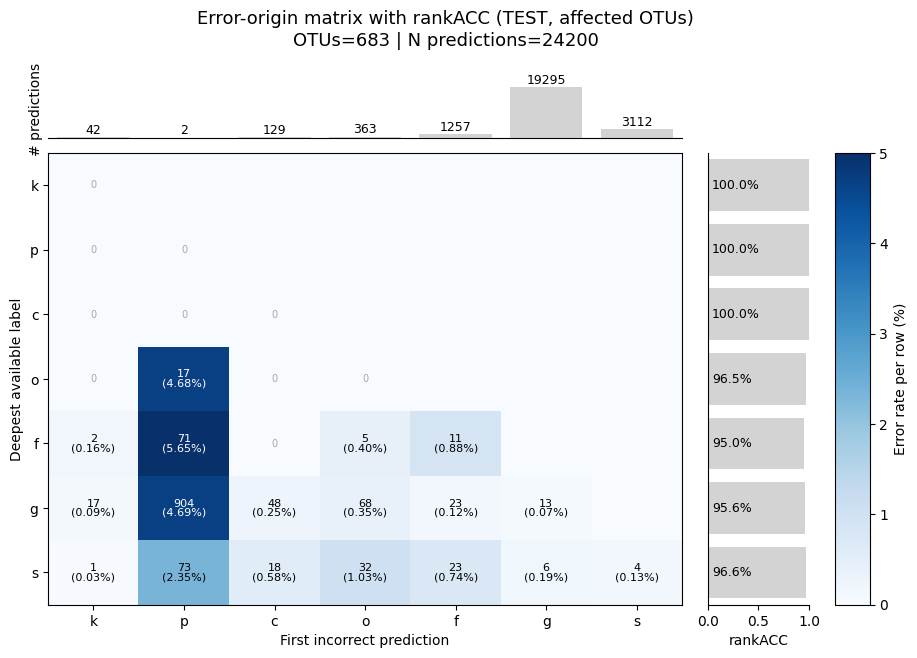

In [17]:
fig, axes = plot_error_origin_matrix_rowpct_colored(
    counts_strict,
    meta_strict,
    title="Error-origin matrix with rankACC (TEST, affected OTUs)",
    ranks=RANKS,
    df=df,
    otu_col="otu_id",
    show_zeros_lower=True,
    show_percent_text=True,  # keep the per-cell row %
    vmax_pct=5.0,            # fixed 0–5% scale for comparability
    vmin_pct=0.0,
)


# table rankACC vs ACC

In [19]:
acc_table = build_accuracy_vs_rankACC_table(df, ranks=RANKS)

# nicer formatting
display(
    acc_table
    .assign(
        standard_accuracy=lambda x: x["standard_accuracy"].map(lambda v: f"{v:.4f}" if pd.notna(v) else "—"),
        rankACC=lambda x: x["rankACC"].map(lambda v: f"{v:.4f}" if pd.notna(v) else "—"),
    )
)


,standard_accuracy,rankACC,n_rows
k,1.0000,1.0000,42
p,1.0000,1.0000,2
c,1.0000,1.0000,129
o,0.9532,0.9649,363
f,0.9292,0.9499,1257
g,0.9444,0.9561,19295
s,0.9496,0.9657,3112
Global,0.9448,0.9575,24200


# comparing results with the real predictions

In [20]:

RANKS = ("k","p","c","o","f","g","s")

def strip_rank_prefix(x: str) -> str:
    if not isinstance(x, str):
        return ""
    x = x.strip()
    if ":" in x:
        return x.split(":", 1)[1].strip()
    return x

def extract_pred_rank_name(pb, r: str) -> str:
    # pb is pred_by_rank dict
    if not isinstance(pb, dict):
        return ""
    rr = pb.get(r, None)
    if not isinstance(rr, dict):
        return ""
    name = rr.get("tax_name", "")
    return strip_rank_prefix(name)

pred_path = Path(OUT_JSONL_AFFECTED)  # set your affected JSONL here
dfp = pd.read_json(pred_path, lines=True)

# this must match SINTAX OTU id string
# (your JSONL already has otu_name)
dfp["otu_key"] = dfp["otu_name"].astype(str)

# predicted names per rank
for r in RANKS:
    dfp[f"pred_{r}_name"] = dfp["pred_by_rank"].apply(lambda d: extract_pred_rank_name(d, r))


In [21]:

true_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/level_97/taxonomy_reference/silva-138.2/vsearch_all_OTUs/repseqs_sintax_v123.txt"

def load_sintax_table(path: str) -> pd.DataFrame:
    # tries common formats: (otu_id, ..., taxonomy) or (otu_id, raw_sintax)
    try:
        df = pd.read_csv(path, sep="\t", header=None, engine="python",
                         usecols=[0,3], names=["otu_id","taxonomy"], dtype=str)
    except Exception:
        df_raw = pd.read_csv(path, sep="\t", header=None, engine="python",
                             usecols=[0,1], names=["otu_id","raw_sintax"], dtype=str)
        def drop_conf(s):
            if pd.isna(s): return ""
            parts = [p.split("(",1)[0].strip() for p in s.strip().rstrip(";").split(",") if ":" in p]
            return ",".join(parts)
        df_raw["taxonomy"] = df_raw["raw_sintax"].apply(drop_conf)
        df = df_raw[["otu_id","taxonomy"]]
    df["taxonomy"] = df["taxonomy"].fillna("")
    return df

def parse_tax_to_cols(series: pd.Series) -> pd.DataFrame:
    ranks = ["k","p","c","o","f","g","s"]
    def to_dict(tax):
        out = {r:"" for r in ranks}
        for part in str(tax).strip().rstrip(";").split(","):
            if ":" not in part: 
                continue
            r, name = part.split(":", 1)
            r = r.strip()
            name = name.split("(", 1)[0].strip()
            if r in out:
                out[r] = name
        return pd.Series(out)
    return series.apply(to_dict)

true_df = load_sintax_table(true_path)
true_cols = parse_tax_to_cols(true_df["taxonomy"])

dft = pd.concat([true_df[["otu_id"]], true_cols], axis=1)
dft = dft.rename(columns={r: f"true_{r}_name" for r in RANKS})

# join key: OTU string id
dft["otu_key"] = dft["otu_id"].astype(str)


In [22]:

RANKS = ("k","p","c","o","f","g","s")

PRED_PATH = Path(OUT_JSONL_AFFECTED)   # or OUT_JSONL_RANDOM
dfp = pd.read_json(str(PRED_PATH), lines=True)

# Join key: prediction OTU string (matches true_df["otu_id"])
dfp["otu_key"] = dfp["otu_name"].astype(str).str.strip()
print("[PRED] rows:", len(dfp), "| unique OTUs:", dfp["otu_key"].nunique())
print("[PRED] preview otu_key:", dfp["otu_key"].head(5).tolist())

dft["otu_key"] = dft["otu_key"].astype(str).str.strip()
print("[TRUE] rows:", len(dft), "| unique OTUs:", dft["otu_key"].nunique())
print("[TRUE] preview otu_key:", dft["otu_key"].head(5).tolist())



[PRED] rows: 24200 | unique OTUs: 683
[PRED] preview otu_key: ['90_21;96_37529;97_47711', '90_196;96_1788;97_2140', '90_15366;96_30286;97_38286', '90_21;96_37529;97_47711', '90_17668;96_69075;97_89749']
[TRUE] rows: 111870 | unique OTUs: 111870
[TRUE] preview otu_key: ['90_18938;96_79042;97_101874', '90_20463;96_79800;97_102794', '90_22156;96_86043;97_110485', '90_19327;96_77520;97_100055', '90_20463;96_79800;97_102793']


In [23]:
df_join = dfp.merge(
    dft.drop(columns=["otu_id"]),   # keep otu_key + true_*_name
    on="otu_key",
    how="left",
    validate="many_to_one"
)

missing = df_join["true_p_name"].isna().mean()
print(f"[JOIN] missing true taxonomy rows: {missing:.2%}")
print("[JOIN] rows:", len(df_join))


[JOIN] missing true taxonomy rows: 0.00%
[JOIN] rows: 24200


In [24]:
def _strip_rank_prefix(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.strip()
    if ":" in s:
        return s.split(":", 1)[1].strip()
    return s

def _pred_name_for_rank(pred_by_rank, r: str) -> str:
    if not isinstance(pred_by_rank, dict):
        return ""
    x = pred_by_rank.get(r, None)
    if not isinstance(x, dict):
        return ""
    return _strip_rank_prefix(x.get("tax_name", ""))

for r in RANKS:
    df_join[f"pred_{r}_name"] = df_join["pred_by_rank"].apply(lambda d: _pred_name_for_rank(d, r))

df_join[["otu_key", "true_p_name", "pred_p_name", "true_g_name", "pred_g_name"]].head(10)



,otu_key,true_p_name,pred_p_name,true_g_name,pred_g_name
0,90_21;96_37529;97_47711,Bacteroidetes,Bacteroidetes,Bacteroides,Bacteroides
1,90_196;96_1788;97_2140,Firmicutes,Firmicutes,Acetivibrio,Acetivibrio
2,90_15366;96_30286;97_38286,Bacteroidetes,Bacteroidetes,Sphingobacterium,Sphingobacterium
3,90_21;96_37529;97_47711,Bacteroidetes,Bacteroidetes,Bacteroides,Bacteroides
4,90_17668;96_69075;97_89749,Euryarchaeota,Firmicutes,Methanobrevibacter,Anaerococcus
5,90_224;96_3191;97_3915,Actinobacteria,Actinobacteria,Actinomyces,Actinomyces
6,90_224;96_3358;97_4119,Actinobacteria,Actinobacteria,Actinomyces,Actinomyces
7,90_7;96_1399;97_1670,Proteobacteria,Bacteroidetes,Taylorella,Alloprevotella
8,90_11422;96_49727;97_64022,Firmicutes,Firmicutes,Weissella,Weissella
9,90_9;96_22874;97_28600,Actinobacteria,Actinobacteria,Arthrobacter,Arthrobacter


In [25]:
def _is_missing_name(x: str) -> bool:
    return (not isinstance(x, str)) or (x.strip() == "") or (x.strip().lower() in {"unknown", "__unknown"})

rows = []
for r in RANKS:
    gold = df_join[f"true_{r}_name"].fillna("").astype(str)
    pred = df_join[f"pred_{r}_name"].fillna("").astype(str)

    valid = ~gold.apply(_is_missing_name)
    n_eval = int(valid.sum())
    acc = float((pred[valid] == gold[valid]).mean()) if n_eval > 0 else float("nan")

    rows.append({"rank": r, "n_eval": n_eval, "acc_non_corrupted": acc})

acc_nc = pd.DataFrame(rows)
display(acc_nc)


,rank,n_eval,acc_non_corrupted
0,k,24200,0.999174
1,p,24200,0.943099
2,c,24200,0.938760
3,o,24200,0.914380
4,f,24200,0.920537
5,g,24198,0.873957
6,s,24200,0.000000


In [26]:
rank_index = {r: i for i, r in enumerate(RANKS)}

def rankACC_non_corrupted_row(row) -> float:
    # deepest available true rank in non-corrupted taxonomy
    deepest = None
    for r in reversed(RANKS):
        if not _is_missing_name(row.get(f"true_{r}_name", "")):
            deepest = r
            break
    if deepest is None:
        return float("nan")

    D = rank_index[deepest] + 1
    m = 0
    for r in RANKS[:D]:
        g = row.get(f"true_{r}_name", "")
        if _is_missing_name(g):
            continue
        p = row.get(f"pred_{r}_name", "")
        if p == g:
            m += 1
        else:
            break
    return float(m / max(1, D))

df_join["rankACC_non_corrupted"] = df_join.apply(rankACC_non_corrupted_row, axis=1)
print("[non-corrupted] Global rankACC (name-based):", float(df_join["rankACC_non_corrupted"].mean()))


[non-corrupted] Global rankACC (name-based): 0.7907438016528926


In [27]:


RANKS = ("k","p","c","o","f","g","s")

def _strip_rank_prefix(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.strip()
    if ":" in s:
        return s.split(":", 1)[1].strip()
    return s

def _pred_name_for_rank(pred_by_rank, r: str) -> str:
    if not isinstance(pred_by_rank, dict):
        return ""
    x = pred_by_rank.get(r, None)
    if not isinstance(x, dict):
        return ""
    return _strip_rank_prefix(x.get("tax_name", ""))

def _is_missing_name(x: str) -> bool:
    return (not isinstance(x, str)) or (x.strip() == "") or (x.strip().lower() in {"unknown","__unknown"})

def build_df_non_corrupted_gold(
    *,
    pred_jsonl_path,
    dft_true,               # your dft: columns otu_key + true_{r}_name
    ranks=RANKS,
):
    dfp = pd.read_json(str(Path(pred_jsonl_path)), lines=True)
    if dfp.empty:
        raise ValueError("Predictions JSONL is empty.")

    # join key (OTU string id)
    dfp["otu_key"] = dfp["otu_name"].astype(str).str.strip()
    dft_true = dft_true.copy()
    dft_true["otu_key"] = dft_true["otu_key"].astype(str).str.strip()

    df = dfp.merge(
        dft_true.drop(columns=["otu_id"], errors="ignore"),
        on="otu_key",
        how="left",
        validate="many_to_one",
    )

    miss = df["true_p_name"].isna().mean()
    print(f"[JOIN] missing non-corrupted taxonomy rows: {miss:.2%}")

    # predictions as names per rank
    for r in ranks:
        df[f"pred_{r}"] = df["pred_by_rank"].apply(lambda d: _pred_name_for_rank(d, r))

    # gold as names per rank (already in dft_true)
    for r in ranks:
        # ensure string, keep missing as ""
        df[f"gold_{r}"] = df.get(f"true_{r}_name", "").fillna("").astype(str)

    return df

# Use your affected JSONL here
df_nc = build_df_non_corrupted_gold(
    pred_jsonl_path=OUT_JSONL_AFFECTED,  # or OUT_JSONL_RANDOM
    dft_true=dft,                        # built from true_df taxonomy (non-corrupted)
    ranks=RANKS,
)

df_nc[["otu_key","gold_p","pred_p","gold_g","pred_g"]].head(10)




[JOIN] missing non-corrupted taxonomy rows: 0.00%


,otu_key,gold_p,pred_p,gold_g,pred_g
0,90_21;96_37529;97_47711,Bacteroidetes,Bacteroidetes,Bacteroides,Bacteroides
1,90_196;96_1788;97_2140,Firmicutes,Firmicutes,Acetivibrio,Acetivibrio
2,90_15366;96_30286;97_38286,Bacteroidetes,Bacteroidetes,Sphingobacterium,Sphingobacterium
3,90_21;96_37529;97_47711,Bacteroidetes,Bacteroidetes,Bacteroides,Bacteroides
4,90_17668;96_69075;97_89749,Euryarchaeota,Firmicutes,Methanobrevibacter,Anaerococcus
5,90_224;96_3191;97_3915,Actinobacteria,Actinobacteria,Actinomyces,Actinomyces
6,90_224;96_3358;97_4119,Actinobacteria,Actinobacteria,Actinomyces,Actinomyces
7,90_7;96_1399;97_1670,Proteobacteria,Bacteroidetes,Taylorella,Alloprevotella
8,90_11422;96_49727;97_64022,Firmicutes,Firmicutes,Weissella,Weissella
9,90_9;96_22874;97_28600,Actinobacteria,Actinobacteria,Arthrobacter,Arthrobacter


In [28]:
def ensure_ok_columns_names(df, ranks=RANKS):
    df = df.copy()
    for r in ranks:
        g = df[f"gold_{r}"].fillna("").astype(str)
        p = df[f"pred_{r}"].fillna("").astype(str)

        has = ~g.apply(_is_missing_name)
        ok = pd.Series(np.nan, index=df.index, dtype="float")
        ok.loc[has] = (p.loc[has].to_numpy() == g.loc[has].to_numpy()).astype(float)
        df[f"ok_{r}"] = ok
    return df

def deepest_gold_rank_names(row, ranks=RANKS):
    for r in reversed(ranks):
        if not _is_missing_name(row.get(f"gold_{r}", "")):
            return r
    return None

def first_wrong_rank_up_to_target(row, target_rank, ranks=RANKS):
    t_idx = ranks.index(target_rank)
    for r in ranks[: t_idx + 1]:
        if _is_missing_name(row.get(f"gold_{r}", "")):
            continue
        ok = row.get(f"ok_{r}", np.nan)
        if (not pd.isna(ok)) and (ok < 0.5):
            return r
    return None

def rankACC_for_row_names(row, target_rank, ranks=RANKS):
    D = ranks.index(target_rank) + 1
    m = 0
    for r in ranks[:D]:
        if _is_missing_name(row.get(f"gold_{r}", "")):
            continue
        ok = row.get(f"ok_{r}", np.nan)
        if pd.isna(ok):
            continue
        if ok >= 0.5:
            m += 1
        else:
            break
    return float(m / max(1, D))

def strict_error_origin_matrix_and_rankACC_names(df, ranks=RANKS):
    df2 = ensure_ok_columns_names(df, ranks=ranks).copy()

    df2["deepest_rank"] = df2.apply(lambda row: deepest_gold_rank_names(row, ranks=ranks), axis=1)
    df2 = df2[df2["deepest_rank"].notna()].copy()

    counts = pd.DataFrame(0, index=ranks, columns=ranks, dtype=int)
    meta_rows = []

    for target in ranks:
        sub = df2[df2["deepest_rank"] == target].copy()
        n_preds = int(len(sub))

        if n_preds == 0:
            meta_rows.append({
                "rank": target,
                "n_preds_strict": 0,
                "n_errors_strict": 0,
                "strict_error_rate": np.nan,
                "rankACC_mean": np.nan,
            })
            continue

        sub["rankACC"] = sub.apply(lambda row: rankACC_for_row_names(row, target, ranks=ranks), axis=1)
        rankACC_mean = float(sub["rankACC"].mean())

        err_mask = sub["rankACC"] < 0.999999
        errs = sub[err_mask].copy()
        n_errors = int(len(errs))

        if n_errors > 0:
            errs["first_wrong"] = errs.apply(
                lambda row: first_wrong_rank_up_to_target(row, target, ranks=ranks),
                axis=1
            )
            vc = errs["first_wrong"].value_counts(dropna=True)
            for col_rank, cnt in vc.items():
                counts.loc[target, col_rank] = int(cnt)

        meta_rows.append({
            "rank": target,
            "n_preds_strict": n_preds,
            "n_errors_strict": n_errors,
            "strict_error_rate": float(n_errors / max(1, n_preds)),
            "rankACC_mean": rankACC_mean,
        })

    meta = pd.DataFrame(meta_rows).set_index("rank")
    return counts, meta, df2

counts_nc, meta_nc, df_nc2 = strict_error_origin_matrix_and_rankACC_names(df_nc, ranks=RANKS)
display(meta_nc)


,n_preds_strict,n_errors_strict,strict_error_rate,rankACC_mean
rank,,,,
k,0,0,NaN,NaN
p,0,0,NaN,NaN
c,0,0,NaN,NaN
o,0,0,NaN,NaN
f,0,0,NaN,NaN
g,0,0,NaN,NaN
s,24200,24200,1.0,0.790744


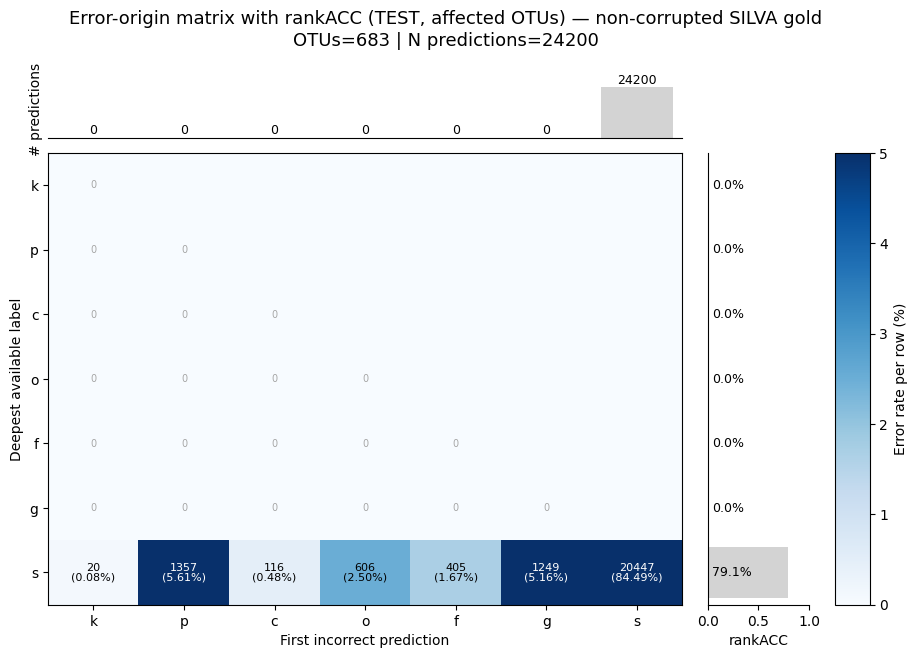

In [32]:
fig, axes = plot_error_origin_matrix_rowpct_colored(
    counts_nc,
    meta_nc,
    title="Error-origin matrix with rankACC (TEST, affected OTUs) — non-corrupted SILVA gold",
    ranks=RANKS,
    df=df_nc2,                 # to show OTUs and N predictions
    otu_col="otu_id",          # or "otu_key"; your df has otu_key (string) and otu_id (numeric)
    show_zeros_lower=True,
    show_percent_text=True,
    vmax_pct=5.0,
    vmin_pct=0.0,
)


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

RANKS = ["k", "p", "c", "o", "f", "g", "s"]

def plot_error_origin_matrix_rowpct_colored_species_only(
    counts,
    meta,
    title,
    ranks=RANKS,
    df=None,
    otu_col="otu_id",
    show_zeros_lower=True,              # kept for signature compatibility
    show_percent_text: bool = True,
    vmax_pct: float = 5.0,
    vmin_pct: float = 0.0,
):
    """
    Species-only error-origin matrix:
      - Heatmap shows only the species row ('s') across columns k..s.
      - Top bar plot shows denominators (# predictions) for ALL deepest ranks (k..s),
        so you can see 0s in k..g and N in s (as in your screenshot).
      - rankACC bar moved to bottom (single bar for species row).
      - The ('s','s') cell is visually distinguished (overlay) to indicate "expected mismatch bucket".
    Signature matches plot_error_origin_matrix_rowpct_colored for drop-in usage.
    """

    ranks = list(ranks)
    if "s" not in ranks:
        raise ValueError("Expected ranks to include 's' for species-only plot.")

    focus_rank = "s"
    row_ranks = [focus_rank]

    # ---- Heatmap counts (single row) ----
    mat_counts = counts.loc[row_ranks, ranks].fillna(0).astype(int)
    data_counts = mat_counts.to_numpy()  # shape (1, C)

    # Denominator for the species row (% per row)
    denom = float(meta.loc[focus_rank, "n_preds_strict"]) if focus_rank in meta.index else 0.0

    # rankACC for species row
    rankacc_val = float(meta.loc[focus_rank, "rankACC_mean"]) if focus_rank in meta.index else 0.0
    if not np.isfinite(rankacc_val):
        rankacc_val = 0.0

    # ---- Top denominators across ALL ranks (k..s) ----
    n_preds_all = meta.loc[ranks, "n_preds_strict"].fillna(0).astype(int).to_numpy()

    # extra info line (same behavior as your original function)
    extra = ""
    if df is not None:
        if otu_col in df.columns:
            n_otus = int(df[otu_col].nunique())
        elif "otu_name" in df.columns:
            n_otus = int(df["otu_name"].nunique())
        else:
            n_otus = None
        n_predictions = int(len(df))
        extra = f"OTUs={n_otus} | N predictions={n_predictions}" if n_otus is not None else f"N predictions={n_predictions}"

    # ---- Row-normalized percent for heatmap colors ----
    data_pct = np.zeros_like(data_counts, dtype=float)
    if denom > 0:
        data_pct[0, :] = 100.0 * (data_counts[0, :] / denom)

    # -------------------------------------------------
    # Layout:
    #   row 0: top denominators bars (all ranks)
    #   row 1: heatmap (species row)
    #   row 2: bottom rankACC bar
    #   col 0: main panels
    #   col 1: colorbar spanning all rows
    # -------------------------------------------------
    fig = plt.figure(figsize=(10.6, 4.5))
    gs = GridSpec(
        3, 2,
        height_ratios=[0.9, 1, 0.5],
        width_ratios=[20, 1.1],
        hspace=0.25,
        wspace=0.10
    )

    # -------------------------
    # Top denominators (all ranks)
    # -------------------------
    ax_top = fig.add_subplot(gs[0, 0])
    ax_top.bar(range(len(ranks)), n_preds_all, color="lightgray", edgecolor="none")
    ax_top.set_xlim(-0.5, len(ranks) - 0.5)
    ax_top.set_ylabel("# predictions")
    ax_top.set_yticks([])
    ax_top.tick_params(axis="y", left=False, labelleft=False)
    ax_top.spines["left"].set_visible(False)
    ax_top.set_xticks([])
    ax_top.tick_params(axis="x", bottom=False, labelbottom=False)
    ax_top.spines["right"].set_visible(False)
    ax_top.spines["top"].set_visible(False)

    ymax = max(1, int(n_preds_all.max()) if len(n_preds_all) else 1)
    ax_top.set_ylim(0, ymax * 1.12)
    for i, n in enumerate(n_preds_all):
        if n > 0:
            ax_top.text(i, n + 0.01 * ymax, f"{n}", ha="center", va="bottom", fontsize=9)

    # -------------------------
    # Heatmap (single row: 's')
    # -------------------------
    ax_hm = fig.add_subplot(gs[1, 0], sharex=ax_top)

    im = ax_hm.imshow(
        data_pct,
        aspect="auto",
        cmap="Blues",
        vmin=vmin_pct,
        vmax=vmax_pct,
    )

    ax_hm.set_xticks(range(len(ranks)))
    ax_hm.set_xticklabels(ranks)
    ax_hm.set_yticks([0])
    ax_hm.set_yticklabels([focus_rank])

    ax_hm.set_xlabel("First incorrect prediction")
    ax_hm.set_ylabel("Available label")

    # annotate: counts and (row %)
    j_species = ranks.index("s")
    for j in range(data_counts.shape[1]):
        v = int(data_counts[0, j])
        pct = float(data_pct[0, j])

        if v > 0:
            txt = f"{v}\n({pct:.2f}%)" if show_percent_text else f"{v}"
            if j == j_species:
                txt_color = "black"
            else:
                txt_color = "white" if pct > 0.6 * vmax_pct else "black"
            ax_hm.text(
                j, 0, txt,
                ha="center", va="center",
                fontsize=8,
                color=txt_color,
                linespacing=0.9,
            )
        else:
            # in your species-only plot, showing zeros everywhere is usually helpful
            ax_hm.text(j, 0, "0", ha="center", va="center", fontsize=7, color="0.65")

    # Highlight ('s','s') cell (fixed style; no new args)
    ax_hm.add_patch(
        Rectangle(
            (j_species - 0.5, -0.5), 1.0, 1.0,
            facecolor="lightgray",
            alpha=1,
            edgecolor="black",
            linewidth=1.0,
            zorder=1,
        )
    )

    # -------------------------
    # Bottom rankACC bar (single)
    # -------------------------
    ax_ra = fig.add_subplot(gs[2, 0])
    ax_ra.barh([0], [rankacc_val], color="lightgray", edgecolor="none")
    ax_ra.set_xlim(0.0, 1.0)
    ax_ra.set_yticks([0])
    ax_ra.set_yticklabels(["rankACC"], rotation=90, va="center")
    ax_ra.text(
        0.01, 0,
        f"{rankacc_val*100:.1f}%",
        va="center", ha="left",
        fontsize=10,
        color="black",
    )
    ax_ra.spines["top"].set_visible(False)
    ax_ra.spines["right"].set_visible(False)

    # -------------------------
    # Colorbar (%), spanning all rows
    # -------------------------
    ax_cb = fig.add_subplot(gs[:, 1])
    cbar = fig.colorbar(im, cax=ax_cb)
    cbar.set_label("Error rate per row (%)")

    # Title
    #fig.suptitle(f"{title}\n{extra}", y=0.98, fontsize=13, linespacing=1.2)

    return fig, (ax_top, ax_hm, ax_ra, ax_cb)


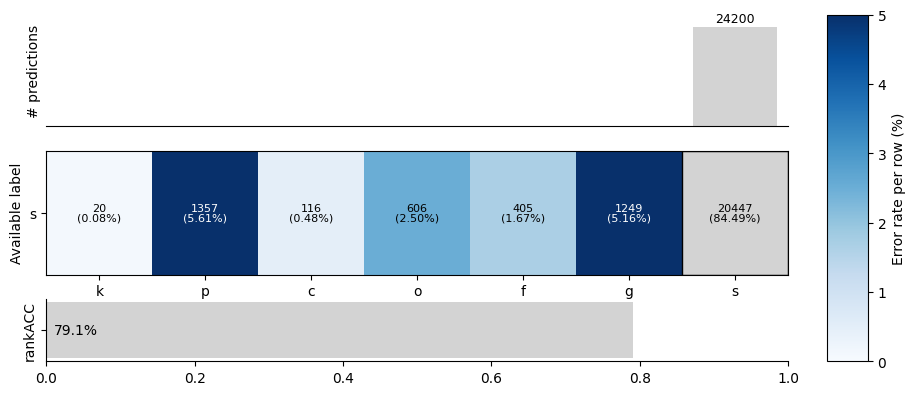

In [69]:
fig, axes = plot_error_origin_matrix_rowpct_colored_species_only(
    counts_nc,
    meta_nc,
    title="Error-origin matrix with rankACC (TEST, affected OTUs) — non-corrupted SILVA gold",
    ranks=RANKS,
    df=df_nc2,
    otu_col="otu_id",
    show_zeros_lower=True,
    show_percent_text=True,
    vmax_pct=5.0,  # for your plot (~84% in the 's' cell)
    vmin_pct=0.0,
)


# cheking wrong predictions "Real" Taxonomy label

In [30]:
RANKS = ["k","p","c","o","f","g","s"]

for r in RANKS:
    df_nc[f"ok_{r}"] = df_nc[f"pred_{r}"] == df_nc[f"gold_{r}"]
def summarize_rank_errors(df, rank, topk=10):
    sub = df[~df[f"ok_{rank}"]].copy()
    if sub.empty:
        return None

    tbl = (
        sub.groupby([f"gold_{rank}", f"pred_{rank}"])
           .size()
           .reset_index(name="count")
           .sort_values("count", ascending=False)
           .head(topk)
    )
    return tbl
for r in RANKS:
    tbl = summarize_rank_errors(df_nc, r, topk=8)
    if tbl is not None:
        print(f"\n=== Top {r.upper()} confusions ===")
        display(tbl)



=== Top K confusions ===


,gold_k,pred_k,count
0,Archaea,Bacteria,20



=== Top P confusions ===


,gold_p,pred_p,count
27,Proteobacteria,Bacteroidetes,223
29,Proteobacteria,Firmicutes,167
23,Firmicutes,Tenericutes,162
0,Acidobacteria,Acetothermia,161
42,Verrucomicrobia,Bacteroidetes,96
33,Spirochaetae,Firmicutes,90
22,Firmicutes,Bacteroidetes,83
2,Actinobacteria,Bacteroidetes,57



=== Top C confusions ===


,gold_c,pred_c,count
2,Acidobacteria,Unknown_Class,161
52,Epsilonproteobacteria,Clostridia,136
61,Erysipelotrichia,Mollicutes,127
98,Verrucomicrobiae,Flavobacteriia,93
90,Spirochaetes,Clostridia,82
54,Epsilonproteobacteria,Flavobacteriia,79
58,Erysipelotrichia,Bacteroidia,76
50,Epsilonproteobacteria,Bacteroidia,74



=== Top O confusions ===


,gold_o,pred_o,count
150,SubsectionIII,SubsectionII,213
34,Campylobacterales,Clostridiales,136
74,Erysipelotrichales,Entomoplasmatales,127
162,Verrucomicrobiales,Flavobacteriales,93
143,Subgroup_4,Unknown_Order,85
11,Aeromonadales,UNK,85
136,Spirochaetales,Clostridiales,82
36,Campylobacterales,Flavobacteriales,79



=== Top F confusions ===


,gold_f,pred_f,count
178,Rhizobiales_Incertae_Sedis,UNK,197
48,Campylobacteraceae,Lachnospiraceae,127
91,Erysipelotrichaceae,Entomoplasmataceae,127
18,Aeromonadaceae,UNK,85
46,Campylobacteraceae,Flavobacteriaceae,79
51,Campylobacteraceae,Prevotellaceae,73
190,Rubritaleaceae,Flavobacteriaceae,50
95,Erysipelotrichaceae,Prevotellaceae,49



=== Top G confusions ===


,gold_g,pred_g,count
223,Luteimonas,UNK,257
274,Phreatobacter,UNK,197
82,Campylobacter,Johnsonella,92
8,Actinobacillus,UNK,88
149,Gemmatimonas,UNK,86
24,Aeromonas,UNK,85
182,Incertae_Sedis,Lachnospiraceae_NK4A136_group,81
86,Campylobacter,Prevotella,55



=== Top S confusions ===


,gold_s,pred_s,count
651,unidentified,UNK,5756
474,Ralstonia_solanacearum,UNK,734
212,Faecalitalea_cylindroides,UNK,625
158,Clostridium_sp._TM-40,UNK,600
215,Filimonas_sp._5GHs7-2,UNK,481
94,Bifidobacterium_choerinum,Bifidobacterium_choerinum_DSM_20434,366
643,unidentified,Eubacterium_coprostanoligenes,308
375,Nocardioides_islandensis,UNK,303


In [31]:
pd.set_option("display.max_colwidth", None)

RANKS = ["k","p","c","o","f","g","s"]

def summarize_rank_errors_with_context(
    df: pd.DataFrame,
    rank: str,
    topk: int = 10,
    otu_col: str = "otu_key",   # change if your OTU id column is different
):
    """
    Top confusion pairs at a given rank with:
      - count: number of prediction rows
      - n_otus: number of unique OTUs contributing
      - gold_lineage: k→...→rank lineage for the gold label (from a representative row)
      - pred_lineage: k→...→rank lineage for the predicted label (from a representative row)
    """
    ok_col = f"ok_{rank}"
    if ok_col not in df.columns:
        raise KeyError(f"Missing {ok_col}. Compute ok_{rank} first.")

    sub = df[~df[ok_col]].copy()
    if sub.empty:
        return None

    gcols = [f"gold_{rank}", f"pred_{rank}"]

    # 1) counts + unique OTUs per confusion pair
    base = (
        sub.groupby(gcols, dropna=False)
           .agg(
               count=(otu_col, "size"),
               n_otus=(otu_col, pd.Series.nunique),
           )
           .reset_index()
    )

    # 2) pick one representative row per confusion pair (for lineage strings)
    first_rows = (
        sub.sort_index()
           .groupby(gcols, dropna=False)
           .head(1)
           .copy()
    )

    r_idx = RANKS.index(rank)
    ranks_upto = RANKS[: r_idx + 1]

    def _lineage(row, prefix: str):
        parts = []
        for r in ranks_upto:
            col = f"{prefix}_{r}"
            val = row.get(col, None)
            if val is None or (isinstance(val, float) and pd.isna(val)):
                continue
            val = str(val).strip()
            if val == "":
                continue
            parts.append(f"{r}:{val}")
        return "; ".join(parts)

    first_rows["gold_lineage"] = first_rows.apply(lambda row: _lineage(row, "gold"), axis=1)
    first_rows["pred_lineage"] = first_rows.apply(lambda row: _lineage(row, "pred"), axis=1)

    ctx = first_rows[gcols + ["gold_lineage", "pred_lineage"]]

    # 3) merge + sort
    tbl = (
        base.merge(ctx, on=gcols, how="left")
            .sort_values("count", ascending=False)
            .head(topk)
            .reset_index(drop=True)
    )
    return tbl


# Example usage (species)
tbl_s = summarize_rank_errors_with_context(df_nc, "s", topk=12, otu_col="otu_key")
display(tbl_s)


,gold_s,pred_s,count,n_otus,gold_lineage,pred_lineage
0,unidentified,UNK,5756,48,k:Bacteria; p:Bacteroidetes; c:Bacteroidia; o:Bacteroidales; f:Bacteroidaceae; g:Bacteroides; s:unidentified,k:Bacteria; p:Bacteroidetes; c:Bacteroidia; o:Bacteroidales; f:Bacteroidaceae; g:Bacteroides; s:UNK
1,Ralstonia_solanacearum,UNK,734,1,k:Bacteria; p:Proteobacteria; c:Betaproteobacteria; o:Burkholderiales; f:Burkholderiaceae; g:Ralstonia; s:Ralstonia_solanacearum,k:Bacteria; p:Proteobacteria; c:Betaproteobacteria; o:Burkholderiales; f:Burkholderiaceae; g:Ralstonia; s:UNK
2,Faecalitalea_cylindroides,UNK,625,2,k:Bacteria; p:Firmicutes; c:Erysipelotrichia; o:Erysipelotrichales; f:Erysipelotrichaceae; g:Faecalitalea; s:Faecalitalea_cylindroides,k:Bacteria; p:Firmicutes; c:Erysipelotrichia; o:Erysipelotrichales; f:Erysipelotrichaceae; g:Faecalitalea; s:UNK
3,Clostridium_sp._TM-40,UNK,600,1,k:Bacteria; p:Firmicutes; c:Erysipelotrichia; o:Erysipelotrichales; f:Erysipelotrichaceae; g:Erysipelatoclostridium; s:Clostridium_sp._TM-40,k:Bacteria; p:Firmicutes; c:Erysipelotrichia; o:Erysipelotrichales; f:Erysipelotrichaceae; g:Erysipelatoclostridium; s:UNK
4,Filimonas_sp._5GHs7-2,UNK,481,1,k:Bacteria; p:Bacteroidetes; c:Sphingobacteriia; o:Sphingobacteriales; f:Chitinophagaceae; g:Parafilimonas; s:Filimonas_sp._5GHs7-2,k:Bacteria; p:Bacteroidetes; c:Sphingobacteriia; o:Sphingobacteriales; f:Chitinophagaceae; g:Parafilimonas; s:UNK
5,Bifidobacterium_choerinum,Bifidobacterium_choerinum_DSM_20434,366,1,k:Bacteria; p:Actinobacteria; c:Actinobacteria; o:Bifidobacteriales; f:Bifidobacteriaceae; g:Bifidobacterium; s:Bifidobacterium_choerinum,k:Bacteria; p:Actinobacteria; c:Actinobacteria; o:Bifidobacteriales; f:Bifidobacteriaceae; g:Bifidobacterium; s:Bifidobacterium_choerinum_DSM_20434
6,unidentified,Eubacterium_coprostanoligenes,308,1,k:Bacteria; p:Firmicutes; c:Clostridia; o:Clostridiales; f:Ruminococcaceae; g:[Eubacterium]_coprostanoligenes_group; s:unidentified,k:Bacteria; p:Firmicutes; c:Clostridia; o:Clostridiales; f:Ruminococcaceae; g:[Eubacterium]_coprostanoligenes_group; s:Eubacterium_coprostanoligenes
7,Nocardioides_islandensis,UNK,303,1,k:Bacteria; p:Actinobacteria; c:Actinobacteria; o:Propionibacteriales; f:Nocardioidaceae; g:Nocardioides; s:Nocardioides_islandensis,k:Bacteria; p:Actinobacteria; c:Actinobacteria; o:Propionibacteriales; f:Nocardioidaceae; g:Nocardioides; s:UNK
8,Pedobacter_insulae,UNK,296,1,k:Bacteria; p:Bacteroidetes; c:Sphingobacteriia; o:Sphingobacteriales; f:Sphingobacteriaceae; g:Pedobacter; s:Pedobacter_insulae,k:Bacteria; p:Bacteroidetes; c:Sphingobacteriia; o:Sphingobacteriales; f:Sphingobacteriaceae; g:Pedobacter; s:UNK
9,Corynebacterium_glutamicum,UNK,290,1,k:Bacteria; p:Actinobacteria; c:Actinobacteria; o:Corynebacteriales; f:Corynebacteriaceae; g:Corynebacterium_1; s:Corynebacterium_glutamicum,k:Bacteria; p:Actinobacteria; c:Actinobacteria; o:Corynebacteriales; f:Corynebacteriaceae; g:Corynebacterium_1; s:UNK


In [35]:
RANKS = ("k","p","c","o","f","g","s")

# -----------------------------
# 0) Ensure ok_* columns exist and are boolean
# -----------------------------
for r in RANKS:
    c = f"ok_{r}"
    if c not in df_nc.columns:
        raise KeyError(f"df_nc is missing {c}. You need ok_* columns computed first.")
    # convert from {0/1, True/False, nan} -> bool (nan treated as False here)
    df_nc[c] = df_nc[c].fillna(False).astype(bool)

# -----------------------------
# 1) Add deepest_rank and (optional) first_wrong to df_nc
# -----------------------------
def _deepest_rank_from_gold(row, ranks=RANKS):
    # gold_* are strings here (names). If empty/None => missing.
    for r in reversed(ranks):
        v = row.get(f"gold_{r}", None)
        if v is not None and str(v).strip() != "":
            return r
    return None

def _first_wrong_rank_up_to_target_from_ok(row, target_rank, ranks=RANKS):
    t_idx = ranks.index(target_rank)
    for r in ranks[: t_idx + 1]:
        v = row.get(f"gold_{r}", None)
        if v is None or str(v).strip() == "":
            continue
        if not bool(row.get(f"ok_{r}", False)):
            return r
    return None

df_nc = df_nc.copy()
df_nc["deepest_rank"] = df_nc.apply(_deepest_rank_from_gold, axis=1)

# Optional: first_wrong (not strictly required for your requested %)
df_nc["first_wrong"] = df_nc.apply(
    lambda row: _first_wrong_rank_up_to_target_from_ok(row, row["deepest_rank"], ranks=RANKS)
    if row["deepest_rank"] in RANKS else None,
    axis=1
)

# -----------------------------
# 2) Helpers: clean + compare species strings
# -----------------------------
def _clean_species_name(s: str) -> str:
    if s is None:
        return ""
    s = str(s).strip()
    s = s.strip("'\"")
    s = s.split("(", 1)[0].strip()
    s = s.replace(" ", "_")

    s = re.sub(
        r"(_(DSM|ATCC|JCM|CCUG|CIP|LMG|NCTC|NBRC|KCTC|IFO|NRRL|MTCC|CGMCC|CECT|BCCM|ICMP|TISTR|TTC|VKPM|KMM|BCRC|NCIMB|GDMCC|CCTCC|GCA|GCF)_?.*)$",
        "",
        s,
        flags=re.IGNORECASE,
    )
    s = re.sub(
        r"(_(strain|str|isolate|isln|clone|cl|sample|bacterium|metagenome)_.*)$",
        "",
        s,
        flags=re.IGNORECASE,
    )
    s = re.sub(r"_+", "_", s).strip("_")
    return s

def _split_genus_species(cleaned: str):
    if not cleaned:
        return ("", "")
    parts = cleaned.split("_")
    if len(parts) < 2:
        return (parts[0], "")
    return (parts[0], parts[1])

def classify_species_only_error(row):
    pred_s = row.get("pred_s", None)
    gold_s = row.get("gold_s", None)

    # 1) explicit UNK / empty
    if pred_s is None:
        return "UNK_species"
    if "UNK" in str(pred_s).upper():
        return "UNK_species"
    if str(pred_s).strip() == "":
        return "UNK_species"

    gold_clean = _clean_species_name(gold_s)
    pred_clean = _clean_species_name(pred_s)

    # 2) genus-correct cases
    if row.get("pred_g", None) == row.get("gold_g", None):
        if gold_clean and pred_clean and (gold_clean.lower() == pred_clean.lower()):
            return "Closest_species"
        g1, e1 = _split_genus_species(gold_clean)
        g2, e2 = _split_genus_species(pred_clean)
        if g1 and g2 and (g1.lower() == g2.lower()) and e1 and e2 and (e1.lower() == e2.lower()):
            return "Closest_species"
        return "Other_species_same_genus"

    # 3) family-correct, genus-wrong
    if row.get("pred_f", None) == row.get("gold_f", None):
        return "Same_family"

    return "Farther_than_family"

# -----------------------------
# 3) Subset: species-only error rows
#    (deepest must be species, all ok up to genus, species wrong)
# -----------------------------
species_only_error = (
    (df_nc["deepest_rank"] == "s") &
    df_nc["ok_k"] & df_nc["ok_p"] & df_nc["ok_c"] &
    df_nc["ok_o"] & df_nc["ok_f"] & df_nc["ok_g"] &
    (~df_nc["ok_s"])
)

df_species_only = df_nc[species_only_error].copy()
df_species_only["species_error_mode"] = df_species_only.apply(classify_species_only_error, axis=1)

# -----------------------------
# 4) NEW %: denominator = ALL species-row predictions (matches your plot row denominator)
# -----------------------------
n_preds_species_row = int((df_nc["deepest_rank"] == "s").sum())
if n_preds_species_row <= 0:
    raise ValueError("No rows with deepest_rank == 's' found; cannot compute row-based percentages.")

mode_counts = df_species_only["species_error_mode"].value_counts(dropna=False).to_frame("count")
mode_counts["pct_of_all_species_row_preds"] = (100.0 * mode_counts["count"] / n_preds_species_row).round(2)

display(mode_counts)

print(
    "[CHECK] species-row denom =", n_preds_species_row,
    "| n_species_only =", len(df_species_only),
    "| sum pct_of_all_species_row_preds =",
    float(mode_counts["pct_of_all_species_row_preds"].sum()),
    "| expected to be <= (s,s) cell % from matrix"
)

# Examples (Closest species)
cols = ["otu_key", "gold_g", "pred_g", "gold_s", "pred_s"]
display(df_species_only[df_species_only["species_error_mode"] == "Closest_species"].head(25)[cols])


,count,pct_of_all_species_row_preds
species_error_mode,,
UNK_species,17599,72.72
Closest_species,1448,5.98
Other_species_same_genus,1398,5.78


[CHECK] species-row denom = 24200 | n_species_only = 20445 | sum pct_of_all_species_row_preds = 84.48 | expected to be <= (s,s) cell % from matrix


,otu_key,gold_g,pred_g,gold_s,pred_s
5,90_224;96_3191;97_3915,Actinomyces,Actinomyces,Actinomyces_cardiffensis,Actinomyces_cardiffensis_F0333
32,90_12;96_1719;97_2058,Burkholderia,Burkholderia,Burkholderia_andropogonis,Burkholderia_andropogonis_Ba3549
41,90_34;96_68;97_71,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_6,Clostridium_cellulovorans,Clostridium_cellulovorans_743B
44,90_507;96_24462;97_30625,[Anaerorhabdus]_furcosa_group,[Anaerorhabdus]_furcosa_group,Erysipelotrichaceae_bacterium_canine_oral_taxon_311,Erysipelotrichaceae_bacterium_feline_oral_taxon_121
56,90_292;96_1143;97_1341,Novispirillum,Novispirillum,Rhodospirillaceae_bacterium_H6167,Rhodospirillaceae_bacterium_H6172
89,90_34;96_68;97_71,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_6,Clostridium_cellulovorans,Clostridium_cellulovorans_743B
97,90_143;96_2090;97_2518,Desulfotalea,Desulfotalea,Desulfotalea_psychrophila_LSv54,Desulfotalea_psychrophila
110,90_34;96_68;97_71,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_6,Clostridium_cellulovorans,Clostridium_cellulovorans_743B
143,90_34;96_68;97_71,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_6,Clostridium_cellulovorans,Clostridium_cellulovorans_743B
155,90_224;96_3191;97_3915,Actinomyces,Actinomyces,Actinomyces_cardiffensis,Actinomyces_cardiffensis_F0333


In [70]:
17599+1448+1398

20445

In [36]:
RANKS = ("k","p","c","o","f","g","s")

# -----------------------------
# 0) Ensure ok_* columns exist and are boolean
# -----------------------------
for r in RANKS:
    c = f"ok_{r}"
    if c not in df_nc.columns:
        raise KeyError(f"df_nc is missing {c}. You need ok_* columns computed first.")
    # convert from {0/1, True/False, nan} -> bool (nan treated as False here)
    df_nc[c] = df_nc[c].fillna(False).astype(bool)

# -----------------------------
# 1) Add deepest_rank and (optional) first_wrong to df_nc
# -----------------------------
def _deepest_rank_from_gold(row, ranks=RANKS):
    # gold_* are strings here (names). If empty/None => missing.
    for r in reversed(ranks):
        v = row.get(f"gold_{r}", None)
        if v is not None and str(v).strip() != "":
            return r
    return None

def _first_wrong_rank_up_to_target_from_ok(row, target_rank, ranks=RANKS):
    t_idx = ranks.index(target_rank)
    for r in ranks[: t_idx + 1]:
        v = row.get(f"gold_{r}", None)
        if v is None or str(v).strip() == "":
            continue
        if not bool(row.get(f"ok_{r}", False)):
            return r
    return None

df_nc = df_nc.copy()
df_nc["deepest_rank"] = df_nc.apply(_deepest_rank_from_gold, axis=1)

# Optional: first_wrong (not strictly required for your requested %)
df_nc["first_wrong"] = df_nc.apply(
    lambda row: _first_wrong_rank_up_to_target_from_ok(row, row["deepest_rank"], ranks=RANKS)
    if row["deepest_rank"] in RANKS else None,
    axis=1
)

# -----------------------------
# 2) Helpers: clean + compare species strings
# -----------------------------
def _clean_species_name(s: str) -> str:
    if s is None:
        return ""
    s = str(s).strip()
    s = s.strip("'\"")
    s = s.split("(", 1)[0].strip()
    s = s.replace(" ", "_")

    s = re.sub(
        r"(_(DSM|ATCC|JCM|CCUG|CIP|LMG|NCTC|NBRC|KCTC|IFO|NRRL|MTCC|CGMCC|CECT|BCCM|ICMP|TISTR|TTC|VKPM|KMM|BCRC|NCIMB|GDMCC|CCTCC|GCA|GCF)_?.*)$",
        "",
        s,
        flags=re.IGNORECASE,
    )
    s = re.sub(
        r"(_(strain|str|isolate|isln|clone|cl|sample|bacterium|metagenome)_.*)$",
        "",
        s,
        flags=re.IGNORECASE,
    )
    s = re.sub(r"_+", "_", s).strip("_")
    return s

def _split_genus_species(cleaned: str):
    if not cleaned:
        return ("", "")
    parts = cleaned.split("_")
    if len(parts) < 2:
        return (parts[0], "")
    return (parts[0], parts[1])

def classify_species_only_error(row):
    pred_s = row.get("pred_s", None)
    gold_s = row.get("gold_s", None)

    # 1) explicit UNK / empty
    if pred_s is None:
        return "UNK_species"
    if "UNK" in str(pred_s).upper():
        return "UNK_species"
    if str(pred_s).strip() == "":
        return "UNK_species"

    gold_clean = _clean_species_name(gold_s)
    pred_clean = _clean_species_name(pred_s)

    # 2) genus-correct cases
    if row.get("pred_g", None) == row.get("gold_g", None):
        if gold_clean and pred_clean and (gold_clean.lower() == pred_clean.lower()):
            return "Closest_species"
        g1, e1 = _split_genus_species(gold_clean)
        g2, e2 = _split_genus_species(pred_clean)
        if g1 and g2 and (g1.lower() == g2.lower()) and e1 and e2 and (e1.lower() == e2.lower()):
            return "Closest_species"
        return "Other_species_same_genus"

    # 3) family-correct, genus-wrong
    if row.get("pred_f", None) == row.get("gold_f", None):
        return "Same_family"

    return "Farther_than_family"

# -----------------------------
# 3) Subset: species-only error rows
#    (deepest must be species, all ok up to genus, species wrong)
# -----------------------------
species_only_error = (
    (df_nc["deepest_rank"] == "s") &
    df_nc["ok_k"] & df_nc["ok_p"] & df_nc["ok_c"] &
    df_nc["ok_o"] & df_nc["ok_f"] & df_nc["ok_g"] &
    (~df_nc["ok_s"])
)

df_species_only = df_nc[species_only_error].copy()
df_species_only["species_error_mode"] = df_species_only.apply(classify_species_only_error, axis=1)

# -----------------------------
# 4) NEW %: denominator = ALL species-row predictions (matches your plot row denominator)
# -----------------------------
n_preds_species_row = int((df_nc["deepest_rank"] == "s").sum())
if n_preds_species_row <= 0:
    raise ValueError("No rows with deepest_rank == 's' found; cannot compute row-based percentages.")

mode_counts = df_species_only["species_error_mode"].value_counts(dropna=False).to_frame("count")
mode_counts["pct_of_all_species_row_preds"] = (100.0 * mode_counts["count"] / n_preds_species_row).round(2)

display(mode_counts)

print(
    "[CHECK] species-row denom =", n_preds_species_row,
    "| n_species_only =", len(df_species_only),
    "| sum pct_of_all_species_row_preds =",
    float(mode_counts["pct_of_all_species_row_preds"].sum()),
    "| expected to be <= (s,s) cell % from matrix"
)

# Examples (Closest species)
cols = ["otu_key", "gold_g", "pred_g", "gold_s", "pred_s"]
display(df_species_only[df_species_only["species_error_mode"] == "Closest_species"].head(25)[cols])


,count,pct_of_all_species_row_preds
species_error_mode,,
UNK_species,17599,72.72
Closest_species,1448,5.98
Other_species_same_genus,1398,5.78


[CHECK] species-row denom = 24200 | n_species_only = 20445 | sum pct_of_all_species_row_preds = 84.48 | expected to be <= (s,s) cell % from matrix


,otu_key,gold_g,pred_g,gold_s,pred_s
5,90_224;96_3191;97_3915,Actinomyces,Actinomyces,Actinomyces_cardiffensis,Actinomyces_cardiffensis_F0333
32,90_12;96_1719;97_2058,Burkholderia,Burkholderia,Burkholderia_andropogonis,Burkholderia_andropogonis_Ba3549
41,90_34;96_68;97_71,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_6,Clostridium_cellulovorans,Clostridium_cellulovorans_743B
44,90_507;96_24462;97_30625,[Anaerorhabdus]_furcosa_group,[Anaerorhabdus]_furcosa_group,Erysipelotrichaceae_bacterium_canine_oral_taxon_311,Erysipelotrichaceae_bacterium_feline_oral_taxon_121
56,90_292;96_1143;97_1341,Novispirillum,Novispirillum,Rhodospirillaceae_bacterium_H6167,Rhodospirillaceae_bacterium_H6172
89,90_34;96_68;97_71,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_6,Clostridium_cellulovorans,Clostridium_cellulovorans_743B
97,90_143;96_2090;97_2518,Desulfotalea,Desulfotalea,Desulfotalea_psychrophila_LSv54,Desulfotalea_psychrophila
110,90_34;96_68;97_71,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_6,Clostridium_cellulovorans,Clostridium_cellulovorans_743B
143,90_34;96_68;97_71,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_6,Clostridium_cellulovorans,Clostridium_cellulovorans_743B
155,90_224;96_3191;97_3915,Actinomyces,Actinomyces,Actinomyces_cardiffensis,Actinomyces_cardiffensis_F0333
